In [1]:
#May have imported too many librarier/packages but rather be safe than sorry
#DEAR PEOPLE IT'S A ROUGH VERSION IF IT HURTS YOUR FEELS TELL ME
import numpy as np
import pandas as pd 

#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

#matplotplib
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline

#Sklearn
import sklearn as sk
import sklearn.datasets
import sklearn.linear_model

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#seaborn 
import seaborn as sns

#Keras 
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import Adam, SGD, Nadam
#https://www.programcreek.com/python/example/104282/keras.optimizers.Adam


Using TensorFlow backend.


In [2]:
#import csv file from OPSCHALER data 
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()
df['gasPower'] = df['gasPower']*10 

#chose to resample to a day
df = df.resample('1D').mean() #Resampling to a day
df['T-1'] = df['T'].shift(1)
df = df.dropna()


In [3]:
from keras import layers

In [4]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,T-1
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,4.857127,9.236111
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,2.768300,8.590000
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.171661,4.746250
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,5.030009,5.606806
2017-02-27,1566.147619,0.0,1828.823593,0.0,253.032893,0.0,1711.548060,192.541318,111.916667,7.891396,...,0.347222,0.208333,8.878611,8.303889,5.900139,81.353472,37413.750102,20.416667,1.315816,8.688750


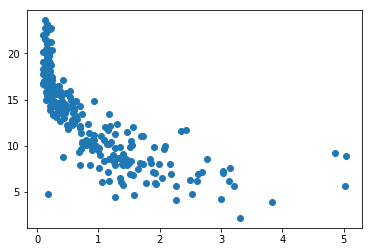

In [8]:
plt.scatter(df['gasPower'],df['T-1'])

In [10]:
#creating dummy variables and adding columns
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)
columns_to_cat = ['hour', 'dayofweek']
df[columns_to_cat] = df[columns_to_cat].astype('category') # change datetypes->category
df = pd.get_dummies(df, columns=columns_to_cat)

In [11]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,T-1,season,hour_0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,9.236111,1,1,0,0,0,1,0,0,0
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,8.590000,1,1,0,0,0,0,1,0,0
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,4.746250,1,1,0,0,0,0,0,1,0
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,5.606806,1,1,0,0,0,0,0,0,1
2017-02-27,1566.147619,0.0,1828.823593,0.0,253.032893,0.0,1711.548060,192.541318,111.916667,7.891396,...,8.688750,1,1,1,0,0,0,0,0,0


In [15]:
X = df[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6','season']]
Y = df[['gasPower']]
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.2)

In [17]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(220, 33) (220, 1)
(55, 33) (55, 1)


In [20]:
model = Sequential()

#first layer with the input data
model.add(Dense(output_dim =16, init = 'uniform', activation = 'relu', input_dim = 9))
#second layer 
model.add(Dense(output_dim = 128, init = 'uniform', activation = 'relu'))
#output layer
model.add(Dense(output_dim = 1))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mape'])

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=16, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128, kernel_initializer="uniform")`
  
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [23]:
model.fit(X_train, Y_train, batch_size =int(len(X_train)),epochs = 100,verbose=1,validation_data=(X_test, Y_test),callbacks=[PlotLossesKeras()])

NameError: name 'PlotLossesKeras' is not defined